# `x-ray-transmission.ipynb`

Author: Niels Vanderloo with inspiration from a MATLAB script by Jacob Pearcy

This notebook is used to plot and fit transmission data taken from the Proto XRD system. https://leia.psfc.mit.edu/wiki/index.php/PROTO-XRD

It requires two uncommon python packages
- `pip install mcareader`
- `pip install xraydb`

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150 # 200 e.g. is really fine, but slower
import mcareader as mca
import numpy as np

In [2]:
# Calibration Coefficients 
# Energy = a *(channel number) + b, taken from DPPMCA for 6/23/23
a=0.04107 
b=-0.370

print("Calibration Coefficients:")
print("Channel", "Energies (keV)")
print(256, a*256+b)
print(1024, a*1024+b)

Calibration Coefficients:
Channel Energies (keV)
256 10.143920000000001
1024 41.685680000000005


In [3]:
# can read MCA files directly
raw = mca.Mca("raw_2_25.mca")     # raw baseline data
filt = mca.Mca("fil4_2_25.mca")   # data with filter/sample

# get exposure time lengths for normalization (in seconds)
raw_exp = float(raw.get_variable("LIVE_TIME"))
filt_exp = float(filt.get_variable("LIVE_TIME"))

# extract just the data
raw = raw.get_points()
filt = filt.get_points()

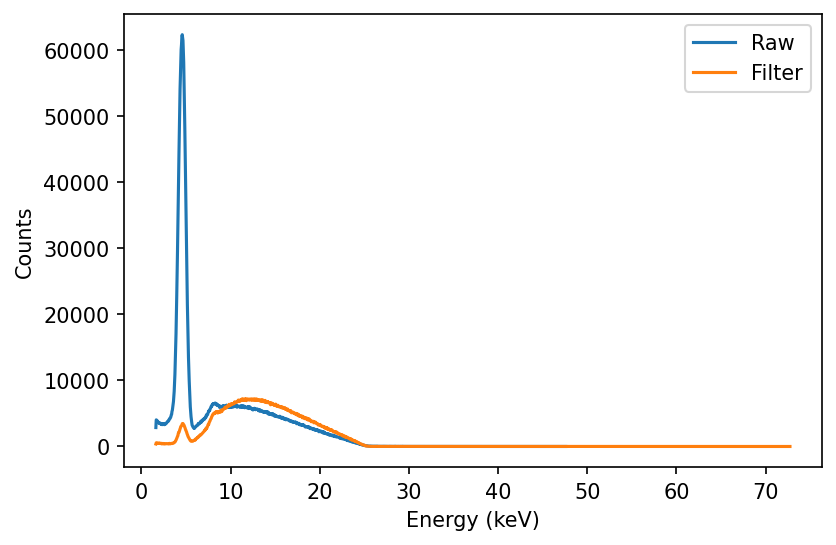

In [4]:
# plot the observed counts for raw and filtered data (not normalized by exposure time)
plt.plot(raw[0],raw[1], label="Raw")
plt.plot(filt[0],filt[1], label="Filter")
plt.xlabel("Energy (keV)")
plt.ylabel("Counts")
plt.legend()
plt.show()

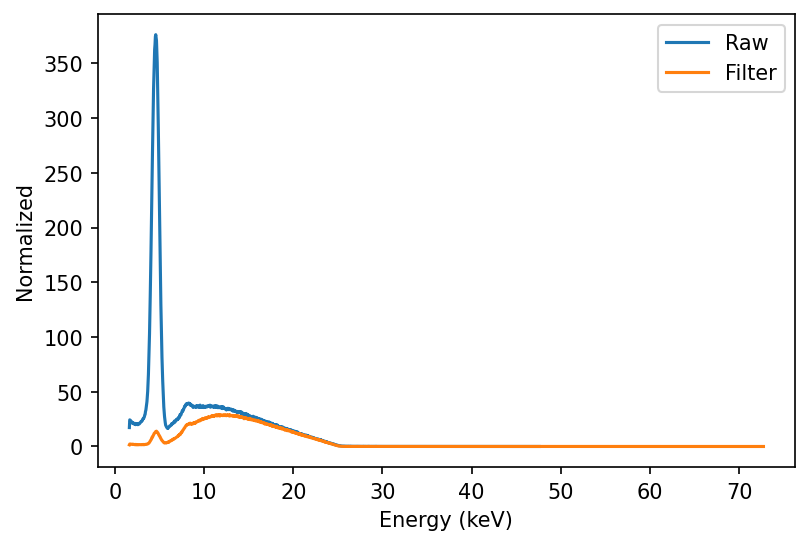

In [5]:
# normalize the data by the exposure time and plot
rawNorm = raw[1]/raw_exp
filtNorm = filt[1]/filt_exp

plt.plot(raw[0],rawNorm, label="Raw")
plt.plot(filt[0],filtNorm, label="Filter")
plt.xlabel("Energy (keV)")
plt.ylabel("Normalized")
plt.legend()
plt.show()

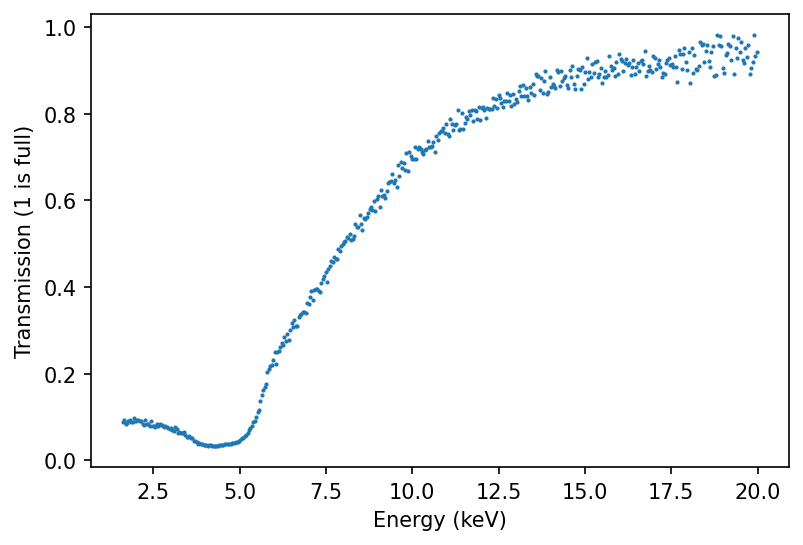

In [6]:
# Crop range of data
emin = 1.5 # keV
emax = 20  # keV
imin = np.argmin(np.abs(raw[0]-emin))
imax = np.argmin(np.abs(raw[0]-emax))

xAxis = raw[0][imin:imax]
rawNorm_crop = rawNorm[imin:imax]
filtNorm_crop = filtNorm[imin:imax]

plt.scatter(xAxis, filtNorm_crop/rawNorm_crop, s=1)
plt.xlabel("Energy (keV)")
plt.ylabel("Transmission (1 is full)")
plt.show()

Material fit to: Al
Fitted thickness: 0.005140101286168348 cm


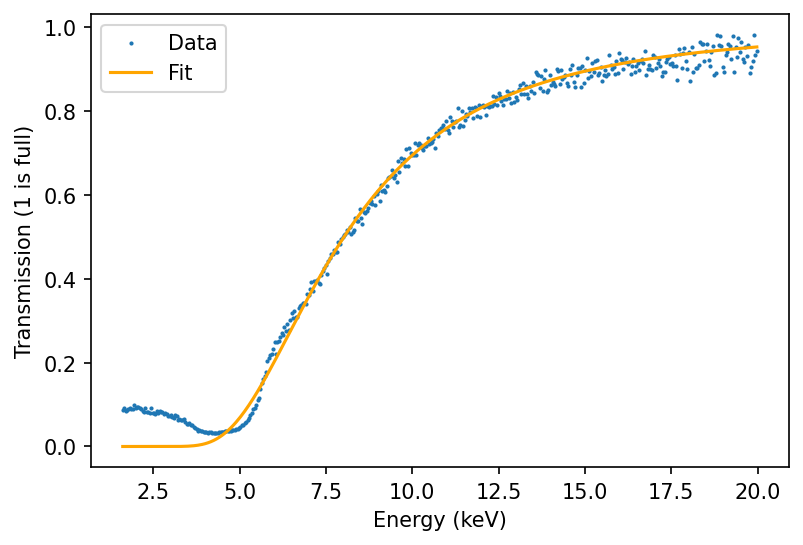

In [7]:
# fit a thickness to the data and plot

import xraydb as xr
from scipy.optimize import curve_fit

# CHANGE MATERIAL
material = 'Al' 
# material = 'Ti'
# material = 'Ta'
# material = 'POLYPROPYLENE'

# list of materials https://github.com/xraypy/XrayDB/blob/4c7ae7ec3278e24335bf487cef7a5b335fbb03d7/python/xraydb/materials.dat#L4
def transmission(energy, thickness):
    return np.exp(-1*xr.material_mu(material, energy)*thickness) # beer's law

energies = xAxis*1e3 # convert to eV
popt, pcov = curve_fit(transmission, energies, filtNorm_crop/rawNorm_crop, bounds=(0,np.inf))

print("Material fit to:", material)
print("Fitted thickness:", popt[0], "cm")

plt.scatter(xAxis, filtNorm_crop/rawNorm_crop, label="Data", s=1)
plt.plot(xAxis, transmission(energies, *popt), label="Fit", c='orange')
plt.xlabel("Energy (keV)")
plt.ylabel("Transmission (1 is full)")
plt.legend()
plt.show()

In [8]:
# example code for calculating transmission fractions for a given material at a given energy
import xraydb as xr

material = 'Al' 
# list of materials https://github.com/xraypy/XrayDB/blob/4c7ae7ec3278e24335bf487cef7a5b335fbb03d7/python/xraydb/materials.dat#L4
energy = 8.0e3 # eV
thickness = 0.005 # cm

transmission = np.exp(-1*xr.material_mu(material, energy)*thickness)
print("Transmission:", transmission)

Transmission: 0.5069538965351187
